In [1]:
from tree_detection_framework.preprocessing.preprocessing import create_dataloader
from tree_detection_framework.detection.detector import Detectree2Detector
from tree_detection_framework.detection.models import Detectree2Module
from tree_detection_framework.postprocessing.postprocessing import multi_region_NMS

/ofo-share/repos-amritha/conda/envs/tdf-test-polygonenms/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataloader = create_dataloader(
    raster_folder_path="/ofo-share/repos-amritha/tree-detection-framework/data/emerald-point-ortho",
    # raster_folder_path="/ofo-share/scratch-derek/tdf-testing/",
    chip_size=512,
    chip_stride=400,
    batch_size=3,
    resolution=0.2,
)

INFO:root:Units = Units.PIXELS
INFO:root:Stride = 400


In [3]:
trained_model = "/ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth"  # Load pretrained weights from local
param_dict = {"update_model": trained_model}

In [4]:
dtree2_module = Detectree2Module(param_dict)
dtree2_detector = Detectree2Detector(dtree2_module)

INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...


In [5]:
dtree2_module.cfg.MODEL.DEVICE

'cuda'

In [6]:
predictions = dtree2_detector.predict(dataloader)

Performing prediction on batches:   0%|          | 0/6 [00:00<?, ?it/s]/ofo-share/repos-amritha/conda/envs/tdf-test-polygonenms/lib/python3.10/site-packages/rasterio/merge.py:483: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  data = src.read(
/ofo-share/repos-amritha/conda/envs/tdf-test-polygonenms/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Performing prediction on batches:  17%|█▋        | 1/6 [00:02<00:14,  2.94s/it]/ofo-share/repos-amritha/conda/envs/tdf-test-polygonenms/lib/python3.10/site-packages/rasterio/merge.py:483: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by th

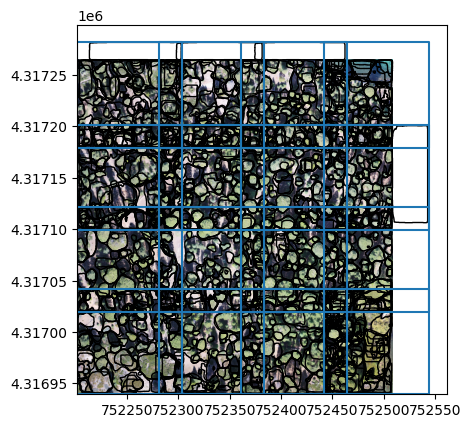

<Axes: >

In [7]:
predictions.plot(
    raster_file="/ofo-share/repos-amritha/tree-detection-framework/data/emerald-point-ortho/ortho.tif"
)

INFO:root:Bound have overlap, running across-region NMS


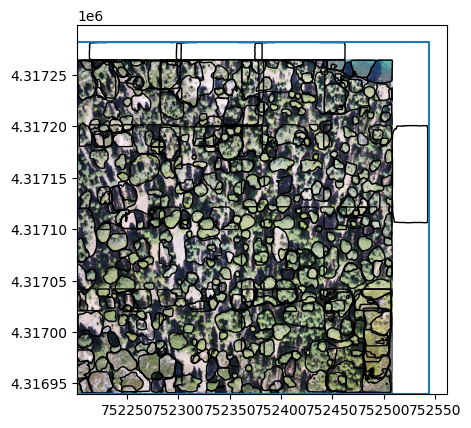

In [9]:
NMS_outputs = multi_region_NMS(
    predictions, confidence_column="score", min_confidence=0.25, threshold=0.5
)
NMS_outputs.plot(
    raster_file="/ofo-share/repos-amritha/tree-detection-framework/data/emerald-point-ortho/ortho.tif"
)